# Epileptic Seizure Detection via CHB-MIT EEG dataset

## 0. dataset description
```
脑电图: EEG
心电图: ECG
肌电图: EMG
眼电图: EOG
皮肤电活动: EDA

chb01: 1 person data

chb01_01.edf: 1 hour data

mne library features: I/O, filter, ICA, time-frequency decompositions (e.g. Wavelet), viz

Brain regions: A = Ear lobe, C = Central, F  = Frontal, Fp = Frontal polar, P = Parietal, Pg = nasopharyngeal, T = Temporal, O = Occipital;
Odd = left side , Even = right side, Z = midline
```

#### International 10-20 system of EEG electrode positions
<img src = './EEG10-20.jpg' alt='drawing' height='350'/>

#### EEG principle
<img src = './principle.jpg' alt='drawing' height='350'/>

#### Bipolar Montage(双极蒙太奇): potential difference(电位差) between 2 electrodes, e.g. F7-T7
<img src = './bipolar_montage.jpg' alt='drawing' height='350'/>

#### EEG waveforms with different frequency
<img src = './diff_freq.jpg' alt='drawing' height='350'/>

#### EEG application 1: epilepsy
<img src = './epilepsy.jpg' alt='drawing' height='350'/>

#### EEG application 2: sleep related disorder(睡眠相关障碍)
<img src = './sleep.jpg' alt='drawing' height='350'/>


In [1]:
import os
import glob 
import math
import re
import numpy as np
from scipy import signal, fft
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import random
import pywt # wavelet
import scipy # wavelet

import mne # for .edf file with EEG data
from mne import Epochs, pick_types, events_from_annotations
from mne.io import concatenate_raws
from mne.io import read_raw_edf
from mne.datasets import eegbci
import pyedflib # for .edf file with EEG data

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier # XGBoost

from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

from utils_eeg import hypers, utils

import warnings
warnings.filterwarnings('ignore')
skf = StratifiedKFold(n_splits=hypers.num_folds, shuffle=True)

#### Approach

```
1. DWT: decompose signals into frequency sub-bands
2. Extract features: get statistical features from sub-bands to represent the distribution of wavelet coefficients 
3. PCA, ICA or LDA: reduce dimension
4. SVM: classify into seizure or non-seizure
```

## 1. get information

In [2]:
with open(r'./CHB-MIT/RECORDS', 'r') as f:
    all_file_list = f.read().splitlines()

all_file_list = ['./CHB-MIT/' + string for string in all_file_list]
print('all file number (seizure & non-seizure):', len(all_file_list))
print(all_file_list[0:3])

all file number (seizure & non-seizure): 686
['./CHB-MIT/chb01/chb01_01.edf', './CHB-MIT/chb01/chb01_02.edf', './CHB-MIT/chb01/chb01_03.edf']


In [3]:
with open(r'./CHB-MIT/RECORDS-WITH-SEIZURES', 'r') as f:
    seizure_file_list = f.read().splitlines()

seizure_file_list = ['./CHB-MIT/' + string for string in seizure_file_list]
print('all file number (seizure):', len(seizure_file_list))
print(seizure_file_list[0:3])

all file number (seizure): 142
['./CHB-MIT/chb01/chb01_03.edf', './CHB-MIT/chb01/chb01_04.edf', './CHB-MIT/chb01/chb01_15.edf']


In [4]:
data_dict = {}
for i in range(1, 4): # all summary files
    id_subject = 'chb' + str(i).zfill(2) # e.g. chb01
    summary_file = r'./CHB-MIT/{}/{}-summary.txt'.format(id_subject, id_subject)
    with open(summary_file, 'r') as f: # each summary file
        print('-----summary file:', summary_file)
        lines = f.readlines()
        for i, line in enumerate(lines):
            edf_file = '/'.join( ['./CHB-MIT', id_subject, line[11:-1]] )
            if edf_file in seizure_file_list: # each seizure file
                print('seizure file:', edf_file)
                start_time = int(re.findall(r'\d+', lines[i+4])[0])
                end_time = int(re.findall(r'\d+', lines[i+5])[0])
                
                data_dict[edf_file] = {'start_time': start_time, 'end_time': end_time}

-----summary file: ./CHB-MIT/chb01/chb01-summary.txt
seizure file: ./CHB-MIT/chb01/chb01_03.edf
seizure file: ./CHB-MIT/chb01/chb01_04.edf
seizure file: ./CHB-MIT/chb01/chb01_15.edf
seizure file: ./CHB-MIT/chb01/chb01_16.edf
seizure file: ./CHB-MIT/chb01/chb01_18.edf
seizure file: ./CHB-MIT/chb01/chb01_21.edf
seizure file: ./CHB-MIT/chb01/chb01_26.edf
-----summary file: ./CHB-MIT/chb02/chb02-summary.txt
seizure file: ./CHB-MIT/chb02/chb02_16.edf
seizure file: ./CHB-MIT/chb02/chb02_16+.edf
seizure file: ./CHB-MIT/chb02/chb02_19.edf
-----summary file: ./CHB-MIT/chb03/chb03-summary.txt
seizure file: ./CHB-MIT/chb03/chb03_01.edf
seizure file: ./CHB-MIT/chb03/chb03_02.edf
seizure file: ./CHB-MIT/chb03/chb03_03.edf
seizure file: ./CHB-MIT/chb03/chb03_04.edf
seizure file: ./CHB-MIT/chb03/chb03_34.edf
seizure file: ./CHB-MIT/chb03/chb03_35.edf
seizure file: ./CHB-MIT/chb03/chb03_36.edf


## 2. read all raw seizure EEG

#### CHB-MIT channels (23)
```
'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 
'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 
'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 
'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 
'FT9-FT10', 'FT10-T8', 'T8-P8-1'
```

#### remove abnormal frequency
```
#### Normal frequency of EEG: 0~50Hz
Band-pass filter: 只传递某频率范围内的信号，由1个Low-pass filter和1个High-pass filter组成
Low-pass filter: 只允许频率低于某频率的信号通过
High-pass filter: 只允许频率高于某频率的信号通过
```

In [5]:
for file_path in data_dict.keys():
    raw_eeg = mne.io.read_raw_edf(file_path, preload=True, verbose=False) # read raw
    raw_eeg.filter(hypers.lowcut, hypers.highcut, method='iir') # band-pass filter
    data, times = raw_eeg[:, :] # or raw_eeg.get_data()
    data = data.astype(np.float32)    
    data = data.T * hypers.scaling_factor # μV -> pV (1e-12 V)
    data_dict[file_path]['data'] = data
    data_dict[file_path]['time'] = times

df = pd.DataFrame(data_dict).T
df = df.reset_index()
df = df.rename(columns={'index':'file_path'})
df

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up b

,file_path,start_time,end_time,data,time
0,./CHB-MIT/chb01/chb01_03.edf,2996,3036,"[[0.2888447, 0.029120019, 0.038055766, 0.05538...","[0.0, 0.00390625, 0.0078125, 0.01171875, 0.015..."
1,./CHB-MIT/chb01/chb01_04.edf,1467,1494,"[[-0.34042767, 0.17725411, -0.068926804, -0.06...","[0.0, 0.00390625, 0.0078125, 0.01171875, 0.015..."
2,./CHB-MIT/chb01/chb01_15.edf,1732,1772,"[[0.37551734, 0.019273758, -0.07045019, -0.328...","[0.0, 0.00390625, 0.0078125, 0.01171875, 0.015..."
3,./CHB-MIT/chb01/chb01_16.edf,1015,1066,"[[0.113242954, -0.040891714, -0.06696916, 0.03...","[0.0, 0.00390625, 0.0078125, 0.01171875, 0.015..."
4,./CHB-MIT/chb01/chb01_18.edf,1720,1810,"[[0.16766965, 0.06327797, 0.14371768, 0.323561...","[0.0, 0.00390625, 0.0078125, 0.01171875, 0.015..."
5,./CHB-MIT/chb01/chb01_21.edf,327,420,"[[-0.12220842, -0.120847315, -0.112686634, -0....","[0.0, 0.00390625, 0.0078125, 0.01171875, 0.015..."
6,./CHB-MIT/chb01/chb01_26.edf,1862,1963,"[[0.4206975, -0.11411732, -0.12237224, 0.10005...","[0.0, 0.00390625, 0.0078125, 0.01171875, 0.015..."
7,./CHB-MIT/chb02/chb02_16.edf,130,212,"[[0.18008727, -0.2173361, 0.47665927, -0.09494...","[0.0, 0.00390625, 0.0078125, 0.01171875, 0.015..."
8,./CHB-MIT/chb02/chb02_16+.edf,2972,3053,"[[0.7346471, -0.35479784, -0.32034904, 0.63109...","[0.0, 0.00390625, 0.0078125, 0.01171875, 0.015..."
9,./CHB-MIT/chb02/chb02_19.edf,3369,3378,"[[-0.16470593, 0.37822768, -0.010328115, 0.080...","[0.0, 0.00390625, 0.0078125, 0.01171875, 0.015..."


In [36]:
# raw_eeg = utils.band_pass(df, hypers.lowcut, hypers.highcut, hypers.sampling_rate) # band-pass filter

In [6]:
##### chb01: 0-6, chb02: 7-9, chb03: 10-16 
# train & val
df_1 = df.iloc[0:7]

# test
df_2 = df.iloc[10:17]

# just check
print(df_1['file_path'])

for d in df_1['data']:
    print(d.shape)

0    ./CHB-MIT/chb01/chb01_03.edf
1    ./CHB-MIT/chb01/chb01_04.edf
2    ./CHB-MIT/chb01/chb01_15.edf
3    ./CHB-MIT/chb01/chb01_16.edf
4    ./CHB-MIT/chb01/chb01_18.edf
5    ./CHB-MIT/chb01/chb01_21.edf
6    ./CHB-MIT/chb01/chb01_26.edf
Name: file_path, dtype: object
(921600, 23)
(921600, 23)
(921600, 23)
(921600, 23)
(921600, 23)
(921600, 23)
(595200, 23)


In [7]:
df_1['end_time'] - df_1['start_time']

0     40
1     27
2     40
3     51
4     90
5     93
6    101
dtype: object

## 3. Visualize Time Domain
```
x-axis: time[s] 
y-axis: Intensity/Amplitude, in this case: Voltage[μV] (心电图强用mV, 脑电图弱用μV) --> 又乘以了1百万，所以是--> [pV]
```

#### show 1 person with 23 channels

Using matplotlib as 2D backend.


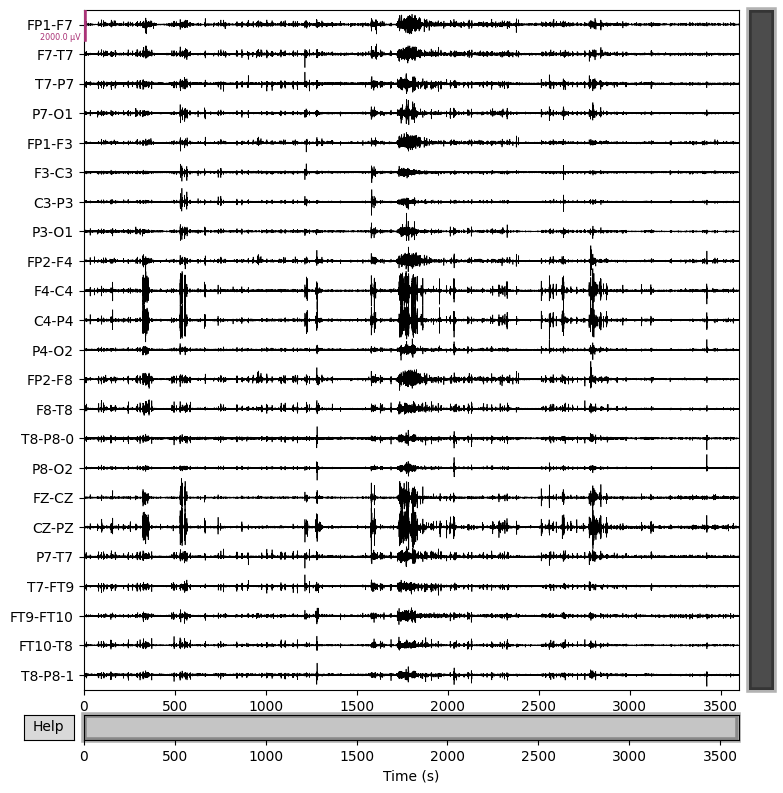

In [8]:
raw_eeg.plot(n_channels=23, start=0, duration=3599, scalings={'eeg': 1e-3}) # start: time[s]
plt.show()

#### show per person, per channel

-------------------
channel_name FP1-F7
-------------------
channel_name F7-T7
-------------------
channel_name T7-P7
-------------------
channel_name P7-O1
-------------------
channel_name FP1-F3
-------------------
channel_name F3-C3
-------------------
channel_name C3-P3
-------------------
channel_name P3-O1
-------------------
channel_name FP2-F4
data id: 0
start: 2996 end: 3036


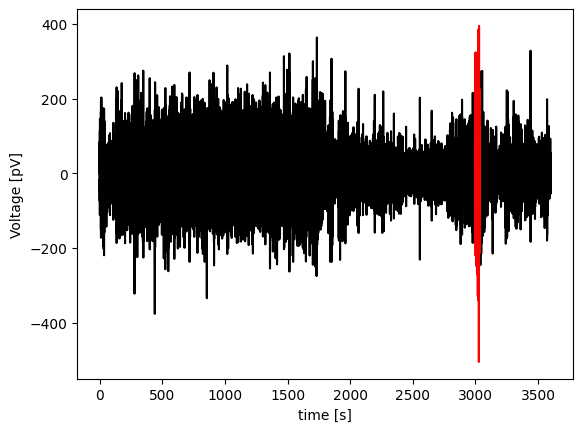

data id: 1
start: 1467 end: 1494


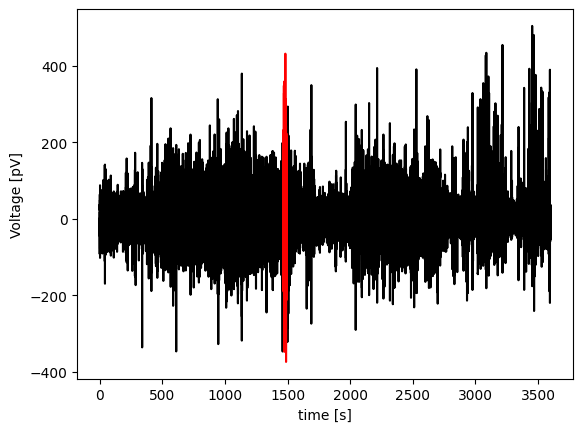

data id: 2
start: 1732 end: 1772


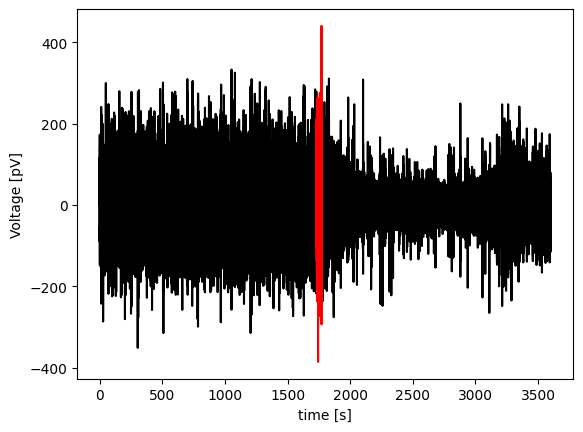

data id: 3
start: 1015 end: 1066


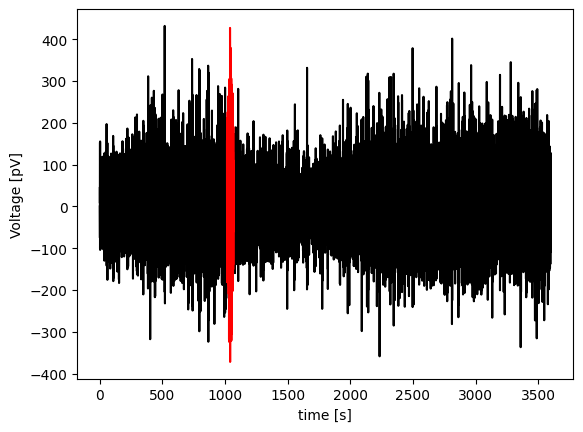

data id: 4
start: 1720 end: 1810


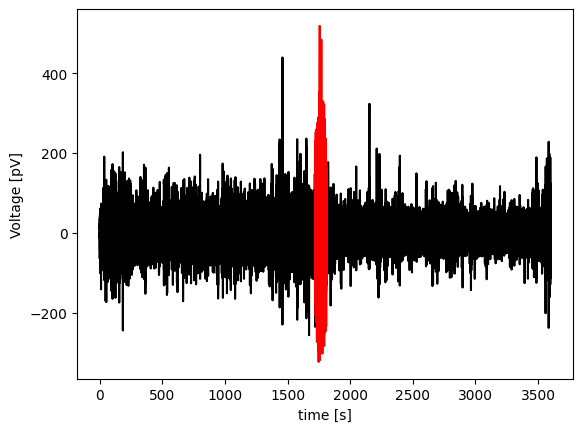

data id: 5
start: 327 end: 420


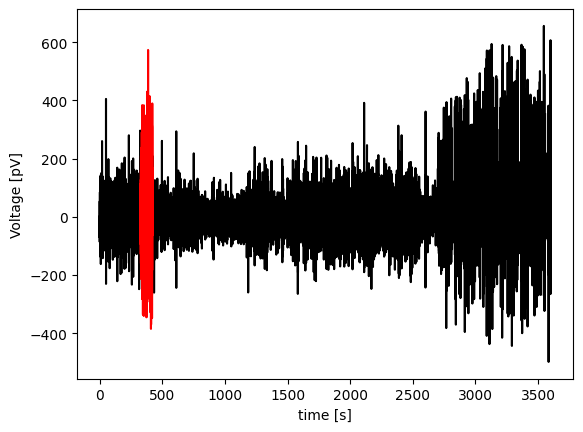

data id: 6
start: 1862 end: 1963


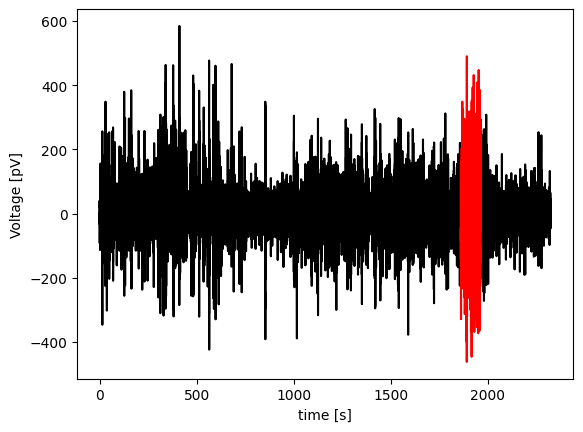

data id: 7
start: 130 end: 212


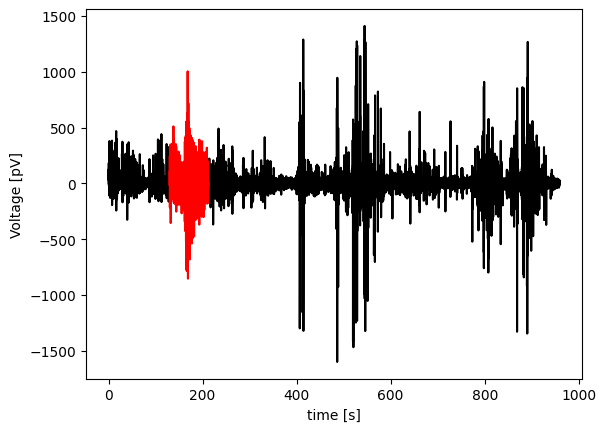

data id: 8
start: 2972 end: 3053


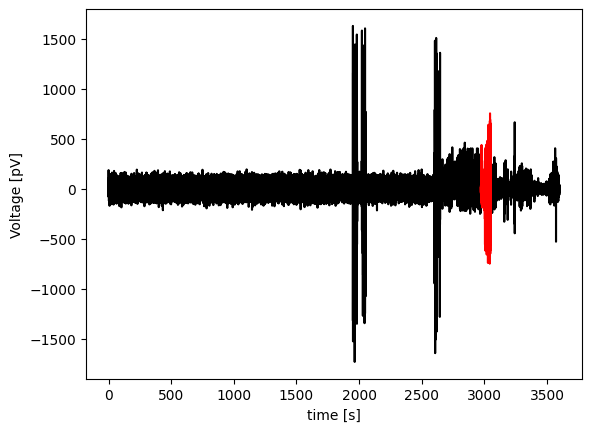

data id: 9
start: 3369 end: 3378


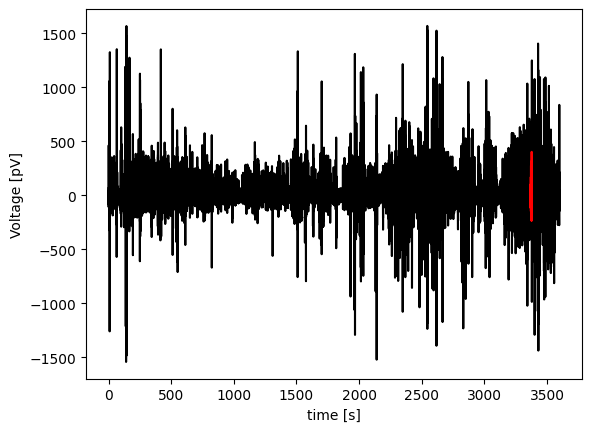

data id: 10
start: 362 end: 414


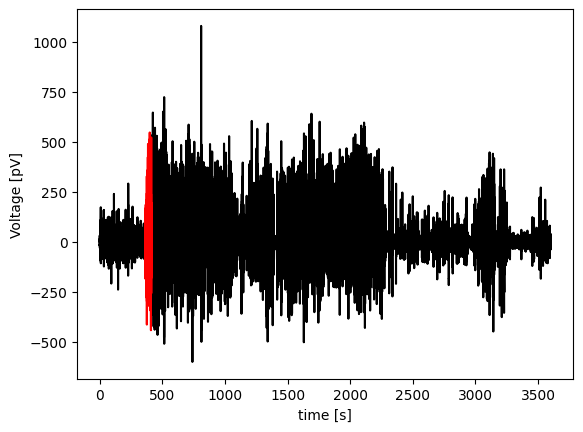

data id: 11
start: 731 end: 796


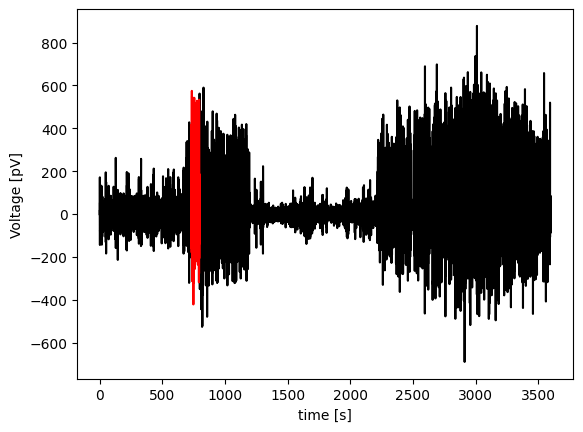

data id: 12
start: 432 end: 501


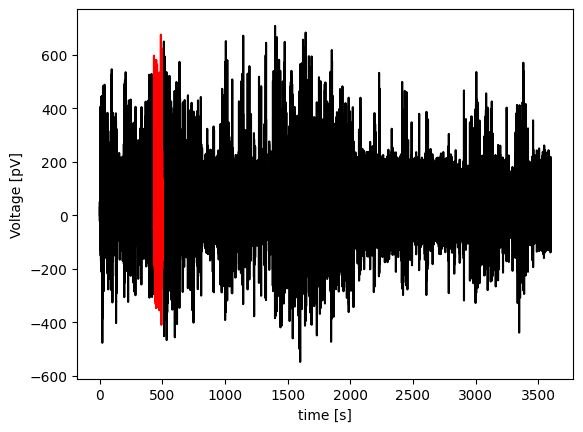

data id: 13
start: 2162 end: 2214


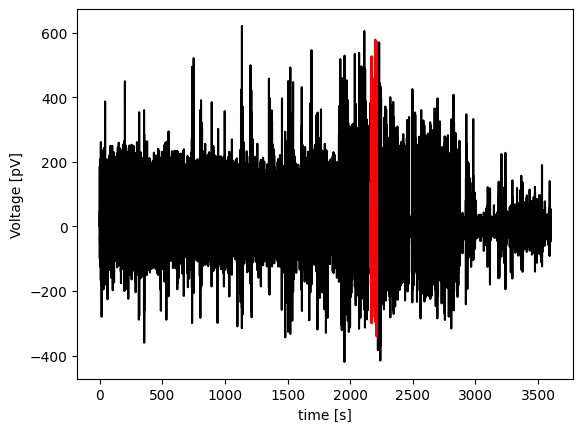

data id: 14
start: 1982 end: 2029


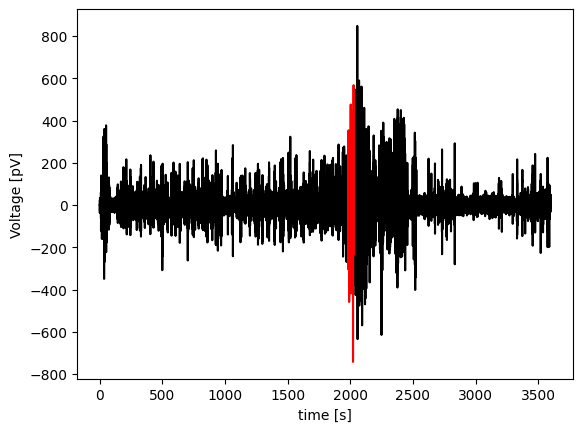

data id: 15
start: 2592 end: 2656


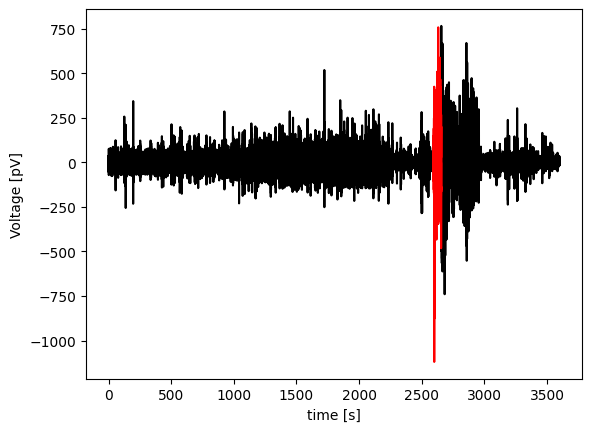

data id: 16
start: 1725 end: 1778


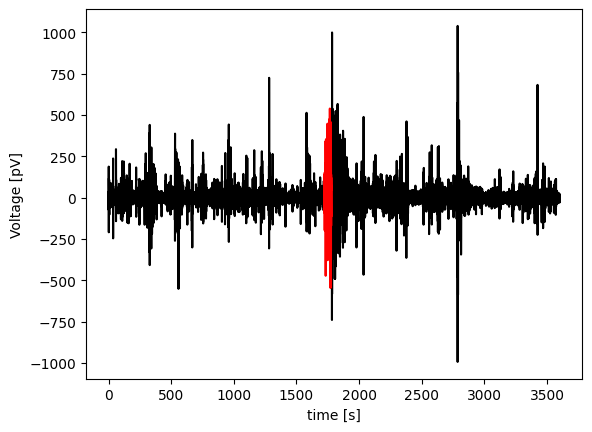

-------------------
channel_name F4-C4
-------------------
channel_name C4-P4
-------------------
channel_name P4-O2
-------------------
channel_name FP2-F8
-------------------
channel_name F8-T8
-------------------
channel_name T8-P8-0
-------------------
channel_name P8-O2
-------------------
channel_name FZ-CZ
-------------------
channel_name CZ-PZ
-------------------
channel_name P7-T7
-------------------
channel_name T7-FT9
-------------------
channel_name FT9-FT10
-------------------
channel_name FT10-T8
-------------------
channel_name T8-P8-1


In [11]:
channel_names = raw_eeg.ch_names
for id_channel, channel_name in enumerate(channel_names):
    print('-------------------')
    print('channel_name', channel_name)

    if channel_name == 'FP2-F4':
        for i in range(len(df)):
            print('data id:', i)
            s = df['start_time'][i]
            e = df['end_time'][i]
            print('start:', s, 'end:', e)
            s = s*hypers.sampling_rate
            e = e*hypers.sampling_rate

            plt.plot(df['time'][i][:s], df['data'][i][:s, id_channel], c='k', label='non-seizure') # left non-seizure
            plt.plot(df['time'][i][e:], df['data'][i][e:, id_channel], c='k', label='non-seizure') # right non-seizure
            plt.plot(df['time'][i][s:e], df['data'][i][s:e, id_channel], c='r', label='seizure') # middle seizure
            plt.xlabel('time [s]')
            plt.ylabel('Voltage [pV]')
            # plt.legend()

            plt.show()

## 4. DWT (Discrete Wavelet Transform)
[Multilevel decomposition using wavedec](https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html#multilevel-decomposition-using-wavedec)

```
Fourier Transform: only applicable to stationary signals (平稳信号: not change much over time), 输入: 时域信号, 输出: 频域信号的函数表示，最后再用窗函数增加时间信息得到频谱图

Wavelet Transform (time–frequency): also applicable to transitory signals (瞬变信号: change much over time), 输入: 时域信号, 输出：不同的小波基函数（e.g. Morlet小波、Haar小波、Daubechies小波）的系数, 这些系数分别表示不同频率的小波基函数的信号强弱, 之后利用不同的系数, 将信号分解成不同频率范围的子信号，因此不用窗函数可以直接得到频谱图

CWT
coeffs, frequencies = pywt.cwt(data, scales, wavelet) # pywt
coeffs = scipy.signal.cwt(data, wavelet, widths) # scipy

DWT
coeffs = pywt.wavedec(data, wavelet, mode, level) # pywt
coeffs = scipy.signal.wavedec(data, wavelet, level) # scipy


Since EEG do not use frequency components above 30 Hz, level number of WT was chosen to be 5

Thus the signal is decomposed into the details D1–D5 and one final approximation, A5 (Table 1)

Coefficients of seizure (Fig. 2), Coefficients of non-seizure (Fig. 3)
```

#### frequency of each sub-band

In [12]:
for i in range(hypers.level):
    lower_limit = hypers.sampling_rate / 2**(i+2)
    upper_limit = hypers.sampling_rate / 2**(i+1)
    print('frequency range (level {}):[{}, {}]'.format(i+1, lower_limit, upper_limit))

print('frequency range (appromaximate):[{}, {}]'.format(0, lower_limit))

frequency range (level 1):[64.0, 128.0]
frequency range (level 2):[32.0, 64.0]
frequency range (level 3):[16.0, 32.0]
frequency range (level 4):[8.0, 16.0]
frequency range (level 5):[4.0, 8.0]
frequency range (appromaximate):[0, 4.0]


#### coefficient number of each sub-band

In [13]:
nums = []
for i in range(hypers.level):
    num = len(d) / 2**(i+1)
    print('level {}: {}'.format(i+1, num))
    nums.append(num)
print('approximate: {}'.format(nums[-1]))
print('sum number:', np.sum(nums) + nums[-1])

level 1: 297600.0
level 2: 148800.0
level 3: 74400.0
level 4: 37200.0
level 5: 18600.0
approximate: 18600.0
sum number: 595200.0


length of original: (921600,)
length of approximate coefficients: (28806,)
length of detailed coefficients (level 5): (28806,)
length of detailed coefficients (level 4): (57606,)
length of detailed coefficients (level 3): (115206,)
length of detailed coefficients (level 2): (230405,)
length of detailed coefficients (level 1): (460803,)


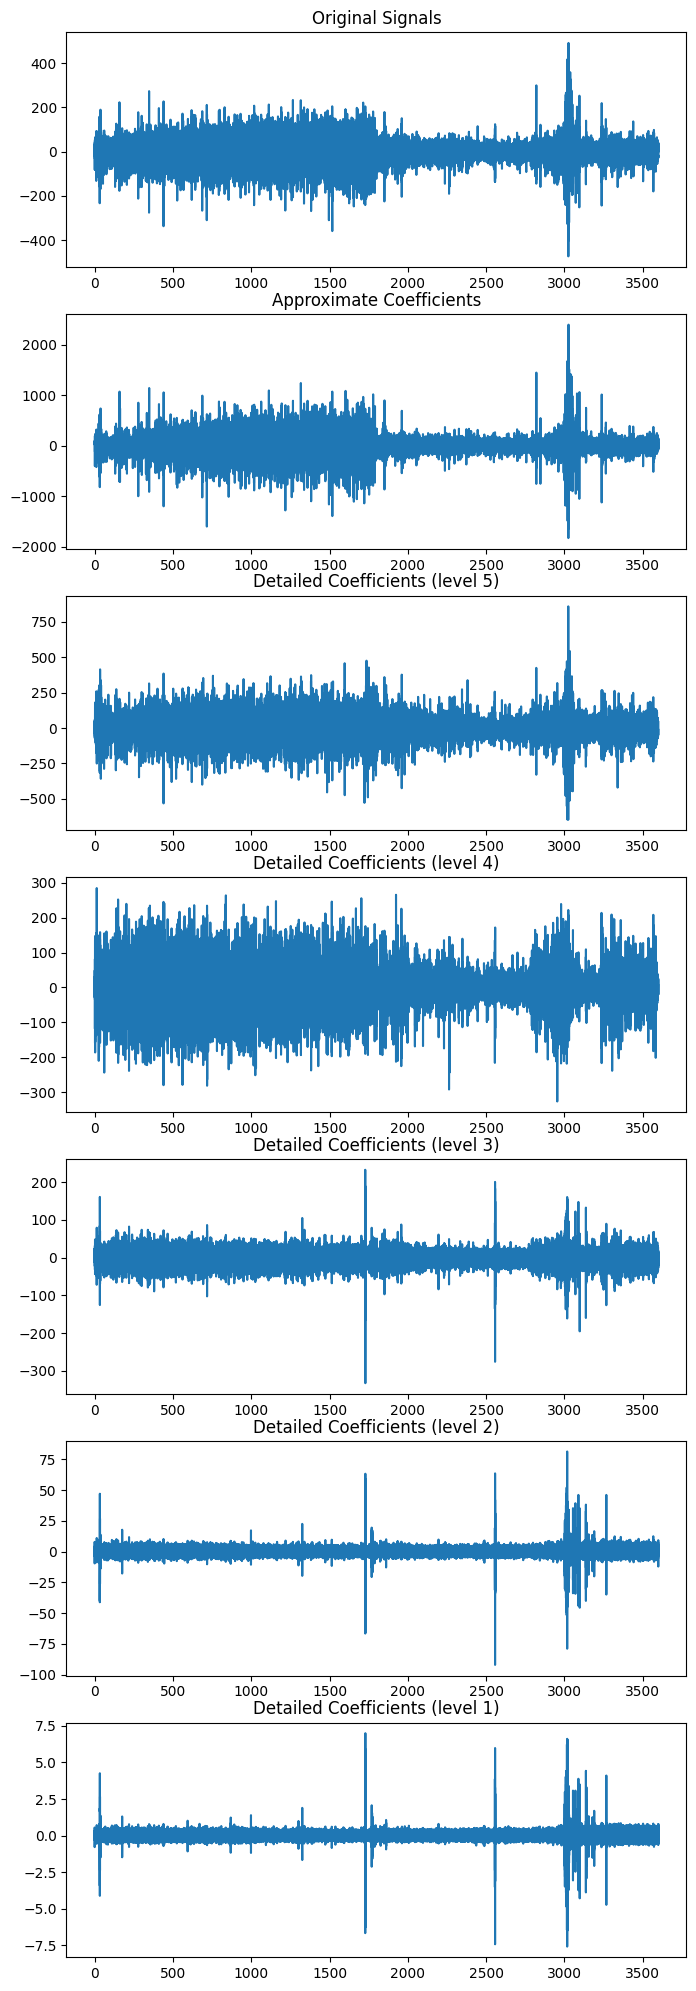

In [14]:
##### original
d = df['data'][0][:, 0]
print('length of original:', d.shape)
# viz 
plt.figure(figsize=(8, 25))
plt.subplot(hypers.level+2, 1, 1)
# plt.plot(d) # x-axis: sample point
plt.plot(np.linspace(0, 3600, len(d)), d) # x-axis: second
plt.title('Original Signals')

##### DWT
coeffs = pywt.wavedec(data=d, wavelet=hypers.wavelet, level=hypers.level)

##### approximate coefficient
approximation = coeffs[0]
print('length of approximate coefficients: {}'.format(approximation.shape))
plt.subplot(hypers.level+2, 1, 2)
# plt.plot(approximation) # x-axis: sample point
plt.plot(np.linspace(0, 3600, len(approximation)), approximation) # x-axis: second
plt.title('Approximate Coefficients')

##### detailed coefficient
details = coeffs[1:] 
for i_, detail in enumerate(details):
    print('length of detailed coefficients (level {}): {}'.format(hypers.level-i_, detail.shape))
    plt.subplot(hypers.level+2, 1, i_+3)
    # plt.plot(detail) # x-axis: sample point
    plt.plot(np.linspace(0, 3600, len(detail)), detail) # x-axis: second
    plt.title('Detailed Coefficients (level {})'.format(hypers.level-i_))

plt.show()

#### 3.1 class 0: DWT for all seizure data (seizure num * channel num * second num)

In [16]:
# train & val
coeffs_seizure_1 = utils.dwt_seizure_per_overlap_window_CHB(df_1, hypers.window_size, hypers.sampling_rate, hypers.wavelet, hypers.level, hypers.moving_size)
print('seizure num * step num, channel num, coeff num (include A ~ D, and label)')
print(coeffs_seizure_1.shape)

# test
coeffs_seizure_2 = utils.dwt_seizure_per_overlap_window_CHB(df_2, hypers.window_size, hypers.sampling_rate, hypers.wavelet, hypers.level, hypers.moving_size)
print('seizure num * step num, channel num, coeff num (include A ~ D, and label)')
print(coeffs_seizure_2.shape)

seizure num * step num, channel num, coeff num (include A ~ D, and label)
(1454, 23, 7)
seizure num * step num, channel num, coeff num (include A ~ D, and label)
(1322, 23, 7)


#### 3.2 class 1: DWT for randomly added non-seizure data (seizure num * channel num * second num)

In [17]:
# train & val
coeffs_non_seizure_1 = utils.dwt_non_seizure_per_window_all_files_CHB(int(len(coeffs_seizure_1)*hypers.label_balance), df_1, hypers.window_size, utils.random_non_seizure_range, hypers.sampling_rate, hypers.wavelet, hypers.level)
print('seizure num * step num, channel num, coeff num (include A ~ D, and label)')
print(coeffs_non_seizure_1.shape)

# test
coeffs_non_seizure_2 = utils.dwt_non_seizure_per_window_all_files_CHB(int(len(coeffs_seizure_2)*hypers.label_balance), df_2, hypers.window_size, utils.random_non_seizure_range, hypers.sampling_rate, hypers.wavelet, hypers.level)
print('seizure num * step num, channel num, coeff num (include A ~ D, and label)')
print(coeffs_non_seizure_2.shape)

seizure num * step num, channel num, coeff num (include A ~ D, and label)
(1454, 23, 7)
seizure num * step num, channel num, coeff num (include A ~ D, and label)
(1322, 23, 7)


#### 3.3 final all coeffs (seizure + non-seizure)

In [18]:
# train & val
coeffs_1 = np.concatenate((coeffs_seizure_1, coeffs_non_seizure_1), axis=0)
print(coeffs_1.shape)

# test
coeffs_2 = np.concatenate((coeffs_seizure_2, coeffs_non_seizure_2), axis=0)
print(coeffs_2.shape)

(2908, 23, 7)
(2644, 23, 7)


## 4. feature extraction & labels

#### features
```
other features:, number of maxima and minima, variance, COV, RMS, Shannon entropy (CMIM is used to select feature type)
```

In [19]:
# train & val
featuress = []
for i in range(coeffs_1.shape[0]): # each data
    features = []
    for j in range(coeffs_1.shape[1]): # each channel
        feature = utils.extract_features(coeffs_1[i][j][0:hypers.used_coeff_num]) # A5, D5, D4, D3
        features.append(feature)
    featuress.append(features)

X = np.array(featuress)
print('features number:', X.shape)
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2]) 
print('final features number:', X.shape)


# test
featuress = []
for i in range(coeffs_2.shape[0]): # each data
    features = []
    for j in range(coeffs_2.shape[1]): # each channel
        feature = utils.extract_features(coeffs_2[i][j][0:hypers.used_coeff_num]) # A5, D5, D4, D3
        features.append(feature)
    featuress.append(features)

X_test = np.array(featuress)
print('features number:', X_test.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2]) 
print('final features number:', X_test.shape)

features number: (2908, 23, 8)
final features number: (2908, 184)
features number: (2644, 23, 8)
final features number: (2644, 184)


#### labels

In [20]:
# train & val
y = coeffs_1[:, 0, hypers.level+1].astype(np.int32)
print(y.shape)
print('seizure num:', sum(y==0))
print('non-seizure num:', sum(y==1))


# train & val
y_test = coeffs_2[:, 0, hypers.level+1].astype(np.int32)
print(y_test.shape)
print('seizure num:', sum(y_test==0))
print('non-seizure num:', sum(y_test==1))

(2908,)
seizure num: 1454
non-seizure num: 1454
(2644,)
seizure num: 1322
non-seizure num: 1322


## 5. data analysis & data pre-processing

#### split to train & test

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True) 
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((2326, 184), (582, 184), (2644, 184), (2326,), (582,), (2644,))

#### normalization

In [22]:
# get scaling factor via training set
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [23]:
# scale train
print(X_train[:, 0].mean(), X_train[:, 0].std())
X_train = scaler.transform(X_train)
print(X_train[:, 0].mean(), X_train[:, 0].std())

# scale val
print(X_val[:, 0].mean(), X_val[:, 0].std())
X_val = scaler.transform(X_val)
print(X_val[:, 0].mean(), X_val[:, 0].std())

# scale test
print(X_test[:, 0].mean(), X_test[:, 0].std())
X_test = scaler.transform(X_test)
print(X_test[:, 0].mean(), X_test[:, 0].std())

# scale train & val (just for hyperparameter tuning)
print(X[:, 0].mean(), X[:, 0].std())
X = scaler.transform(X)
print(X[:, 0].mean(), X[:, 0].std())

0.7321639 216.54242
0.42971137 0.08622
6.5186706 228.74698
0.4320154 0.09107944
2.595705 208.54709
0.4304534 0.08303653
1.8902618 219.05168
0.4301725 0.087219104


#### just for quick check

----------train----------
                precision    recall  f1-score   support

    0: seizure       1.00      1.00      1.00      1147
1: non-seizure       1.00      1.00      1.00      1179

      accuracy                           1.00      2326
     macro avg       1.00      1.00      1.00      2326
  weighted avg       1.00      1.00      1.00      2326



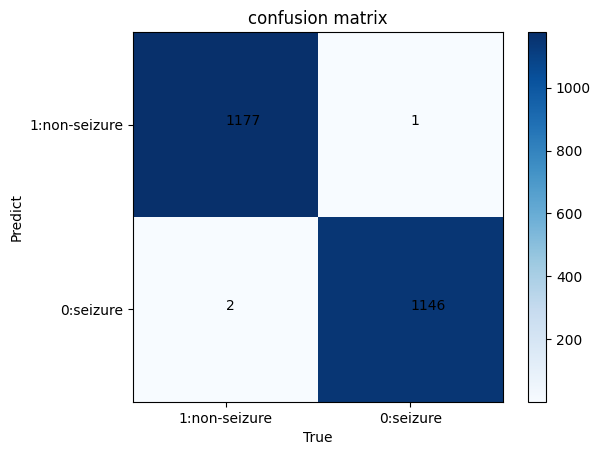

----------val----------
                precision    recall  f1-score   support

    0: seizure       0.94      0.99      0.97       307
1: non-seizure       0.99      0.93      0.96       275

      accuracy                           0.96       582
     macro avg       0.97      0.96      0.96       582
  weighted avg       0.96      0.96      0.96       582



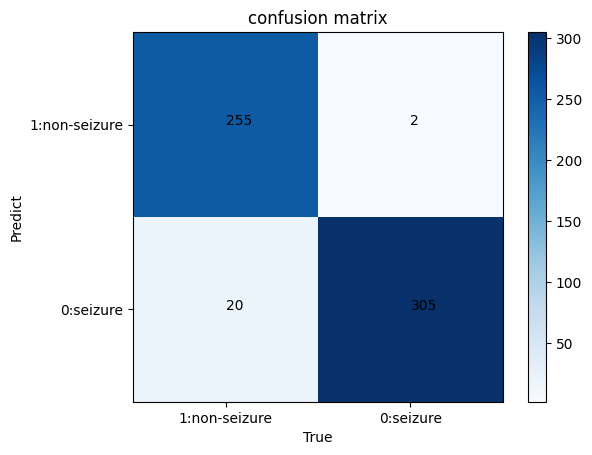

----------test----------
                precision    recall  f1-score   support

    0: seizure       0.94      0.88      0.91      1322
1: non-seizure       0.89      0.94      0.91      1322

      accuracy                           0.91      2644
     macro avg       0.91      0.91      0.91      2644
  weighted avg       0.91      0.91      0.91      2644



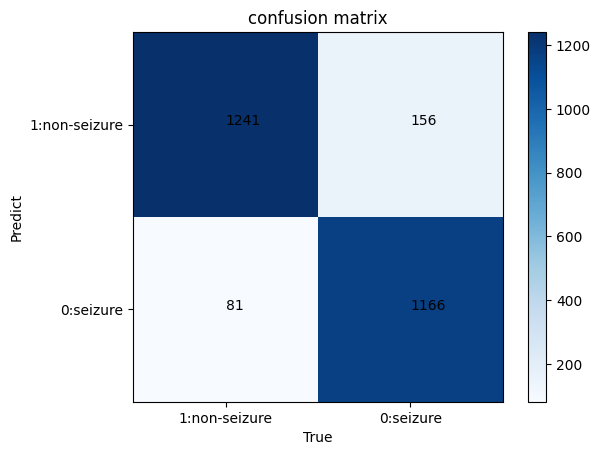

In [30]:
# clf = SVC(kernel='rbf', C=10, gamma=0.1, probability=True)
clf = XGBClassifier(verbosity=0, probability=True)
clf.fit(X_train, y_train)

# train
print('----------train----------')
y_pred = clf.predict(X_train)
print(classification_report(y_train, y_pred, target_names=hypers.labels))
utils.confusion_matrix(y_train, y_pred)

# val
print('----------val----------')
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred, target_names=hypers.labels))
utils.confusion_matrix(y_val, y_pred)

# test
print('----------test----------')
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=hypers.labels))
utils.confusion_matrix(y_test, y_pred)

## 6. PCA

In [25]:
# model
pca = PCA(n_components=10)
# train
X_pca = pca.fit_transform(X)
X_pca.shape

(2908, 10)

#### visualize PC distribution

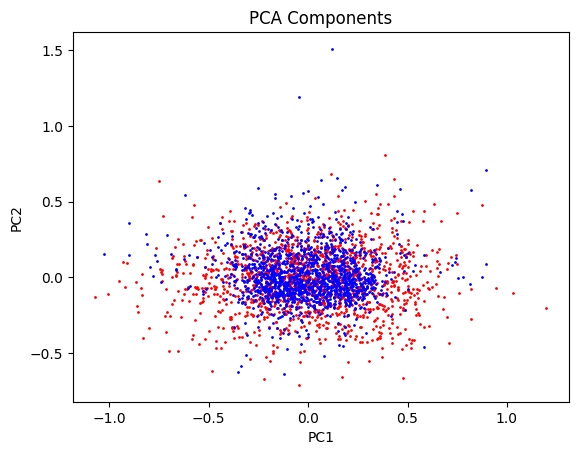

In [26]:
colors = ['red', 'blue']
for i in range(len(X_pca)):
    plt.scatter(X_pca[i, 4], X_pca[i, 9], color=colors[y[i]], s=1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Components')
plt.show()

## 7. just find good models (via training set & validation set)

In [27]:
models = [LogisticRegression(), SVC(), LinearSVC(), DecisionTreeClassifier(), RandomForestClassifier(),
          ExtraTreesClassifier(), GradientBoostingClassifier(), XGBClassifier(), KNeighborsClassifier(), GaussianNB()
]

names = ['LogisticRegression', 'SVC', 'LinearSVC', 'DecisionTreeClassifier', 'RandomForestClassifier',
          'ExtraTreesClassifier', 'GradientBoostingClassifier', 'XGBClassifier', 'KNeighborsClassifier', 'GaussianNB'
]

#### cross validation (or stratified K-folds) & various metrics 

In [28]:
def acc_cv(model, X, y):
    acc = cross_val_score(model, X, y, scoring='accuracy', cv=skf) # cv=num_folds for cross-validation, or cv=skf for stratified K-folds cross-validation
    return acc
def balanced_acc_cv(model, X, y):
    balanced_acc = cross_val_score(model, X, y, scoring=make_scorer(balanced_accuracy_score), cv=skf)
    return balanced_acc
def precision_cv(model, X, y):
    precision = cross_val_score(model, X, y, scoring='precision', cv=skf)
    return precision
def recall_cv(model, X, y):
    recall = cross_val_score(model, X, y, scoring='recall', cv=skf)
    return recall
def f1_score_cv(model, X, y):
    f1_score = cross_val_score(model, X, y, scoring='f1', cv=skf)
    return f1_score
def auc_cv(model, X, y):
    auc = cross_val_score(model, X, y, scoring=make_scorer(roc_auc_score), cv=skf)
    return auc

#### can select with PCA or without PCA

In [29]:
for name, model in zip(names, models):
    print('----------', name, '----------')
    # acc
    score = acc_cv(model, X, y) # or X_pca, y
    print('{:<20}    mean: {:.4f}    std: {:.4f}'.format('||acc||', score.mean(), score.std()))
    # balanced acc
    score = balanced_acc_cv(model, X, y) # or X_pca, y
    print('{:<20}    mean: {:.4f}    std: {:.4f}'.format('||balanced_acc||', score.mean(), score.std()))
    # precision
    score = precision_cv(model, X, y) # or X_pca, y
    print('{:<20}    mean: {:.4f}    std: {:.4f}'.format('||precision||', score.mean(), score.std()))
    # recall
    score = recall_cv(model, X, y) # or X_pca, y
    print('{:<20}    mean: {:.4f}    std: {:.4f}'.format('||recall||', score.mean(), score.std()))
    # f1-score
    score = f1_score_cv(model, X, y) # or X_pca, y
    print('{:<20}    mean: {:.4f}    std: {:.4f}'.format('||f1||', score.mean(), score.std()))
    # auc
    score = auc_cv(model, X, y) # or X_pca, y
    print('{:<20}    mean: {:.4f}    std: {:.4f}'.format('||auc||', score.mean(), score.std()))
    print()

---------- LogisticRegression ----------
||acc||                 mean: 0.9653    std: 0.0025
||balanced_acc||        mean: 0.9639    std: 0.0060
||precision||           mean: 0.9681    std: 0.0085
||recall||              mean: 0.9567    std: 0.0200
||f1||                  mean: 0.9634    std: 0.0113
||auc||                 mean: 0.9642    std: 0.0033

---------- SVC ----------
||acc||                 mean: 0.9673    std: 0.0027
||balanced_acc||        mean: 0.9680    std: 0.0058
||precision||           mean: 0.9824    std: 0.0091
||recall||              mean: 0.9539    std: 0.0093
||f1||                  mean: 0.9679    std: 0.0070
||auc||                 mean: 0.9666    std: 0.0058

---------- LinearSVC ----------
||acc||                 mean: 0.9639    std: 0.0058
||balanced_acc||        mean: 0.9598    std: 0.0088
||precision||           mean: 0.9660    std: 0.0135
||recall||              mean: 0.9532    std: 0.0149
||f1||                  mean: 0.9612    std: 0.0050
||auc||        

## 8. hyperparameter tuning for getting best model (via training set & validation set)

#### grid search (or randomized search) & cross validation (or stratified K-folds)

In [ ]:
class GridSearch():
    def __init__(self, model):
        self.model = model
    
    def grid_get(self, X, y, param_grid, metric):
        grid_search_CV = GridSearchCV(estimator=self.model, param_grid=param_grid, cv=skf, scoring=metric)
        grid_search_CV.fit(X, y)
        
        best_params = grid_search_CV.best_params_
        best_score = grid_search_CV.best_score_
        print('best params:', best_params)
        print('best score:', best_score)
        # grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        # print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])
        
        return best_params, grid_search_CV


class RandomizedSearch():
    def __init__(self, model):
        self.model = model
    
    def grid_get(self, X, y, random_grid, metric):
        randomized_search_CV = RandomizedSearchCV(
            estimator=model, 
            param_distributions = random_grid, 
            n_iter=100, 
            cv=skf, 
            scoring=metric,
            verbose=2, 
            random_state=4321, 
            n_jobs=-1
        )       
        randomized_search_CV.fit(X, y)

        best_params = randomized_search_CV.best_params_
        best_score = randomized_search_CV.best_score_
        print('best params:', best_params)
        print('best score:', best_score)
    
        return best_params, randomized_search_CV

#### SVC (grid search)

In [ ]:
param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
    'C': [0.1, 1, 10, 100],
    'gamma': [0.1, 0.001, 0.0001]
}

model = SVC(random_state=4321, probability=True)
best_params, gs_cv = GridSearch(model).grid_get(X, y, param_grid, hyper_search_metric)
best_model_svc = gs_cv.best_estimator_

#### SVC (randomized search)

In [ ]:
# random_grid = {
#     'kernel': ['linear', 'rbf', 'poly'],
#     'C': uniform(loc=0.1, scale=10),
#     'gamma': [0.1, 0.001, 0.0001] # 'gamma': ['scale', 'auto']
# }

# model = SVC(random_state=4321)
# best_params, gs_cv = RandomizedSearch(model).grid_get(X, y, random_grid, hyper_search_metric)
# best_model_svc = gs_cv.best_estimator_

#### LinearSVC (grid search)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'dual': [True, False], # set dual=False when n_samples > n_features
}

model = LinearSVC(random_state=4321)
best_params, gs_cv = GridSearch(model).grid_get(X, y, param_grid, hyper_search_metric)
best_model_linearsvc = gs_cv.best_estimator_

#### RandomForest (randomized search)

In [ ]:
random_grid = {
    'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4], 
    'bootstrap': [True, False]
}

model = RandomForestClassifier(random_state=4321)
best_params, gs_cv = RandomizedSearch(model).grid_get(X, y, random_grid, hyper_search_metric)
best_model_randomforest = gs_cv.best_estimator_

#### ExtraTreesClassifier (grid search)

In [ ]:
param_grid = {
    'n_estimators': [320, 340, 360, 380, 400],
    'max_depth': [25, 30, 32, 34, 38, 45]
}

model = ExtraTreesClassifier(random_state=4321)
best_params, gs_cv = GridSearch(model).grid_get(X, y, param_grid, hyper_search_metric)
best_model_extratrees = gs_cv.best_estimator_

#### GBDT (grid search)

In [ ]:
param_grid = {
    #'nthread':[3,4], # when use hyperthread, xgboost may become slower
    'criterion': ['friedman_mse', 'mae'],
    'loss': ['deviance', 'exponential'],
    'max_features': ['log2', 'sqrt'],
    'learning_rate': [0.01, 0.05, 0.1, 1, 0.5],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [4, 5, 6],
    'subsample': [0.6, 0.7, 0.8],
    'n_estimators': [5, 10, 15, 20], # number of trees, change it to 1000 for better results
}

model = GradientBoostingClassifier(random_state=4321)
best_params, gs_cv = GridSearch(model).grid_get(X, y, param_grid, hyper_search_metric)
best_model_gbdt = gs_cv.best_estimator_

#### XGBoost (grid search)

In [ ]:
param_grid = {
    'nthread':[2, 3],
    'eta': [0.01, 0.1, 1.0],
    'gamma':[0, 0.1], 
    'n_estimators':[10, 100],
    'max_depth':[2, 4], 
    'min_child_weigh':[1, 2]
}

model = XGBClassifier(random_state=4321, verbosity=0, probability=True) 
best_params, gs_cv = GridSearch(model).grid_get(X, y, param_grid, hyper_search_metric)
best_model_xgboost = gs_cv.best_estimator_

#### KNN (grid search)

In [ ]:
param_grid = {
    'n_neighbors':list(range(1, 31))
}

model = KNeighborsClassifier()
best_params, gs_cv = GridSearch(model).grid_get(X, y, param_grid, hyper_search_metric)
best_model_knn = gs_cv.best_estimator_

In [ ]:
# # logistic regression
# {'C':[11,12,13,14,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]}

# # decision tree
# "criterion":("gini", "entropy"), "splitter":("best", "random"), "max_depth":(list(range(1, 20))), "min_samples_split":[2, 3, 4], "min_samples_leaf":list(range(1, 20)), 

# # naive bayes
# {'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]}

## 9. final test (via test set)

In [ ]:
best_model_list = [best_model_svc, best_model_linearsvc, best_model_randomforest, best_model_extratrees, best_model_gbdt, best_model_xgboost, best_model_knn]

In [ ]:
def report_and_confusion_matrix(best_model_list, X_train, y_train, X_val, y_val, X_test, y_test):
    for best_model in best_model_list:
        print('==================== {} ===================='.format(best_model.__class__.__name__))
        # train
        y_train_pred = best_model.predict(X_train)
        print('========== train ==========')
        print(classification_report(y_train, y_train_pred, target_names=labels))
        confusion_matrix(y_train, y_train_pred)
        # val
        y_val_pred = best_model.predict(X_val)
        print('========== val ==========')
        print(classification_report(y_val, y_val_pred, target_names=labels))
        confusion_matrix(y_val, y_val_pred)
        # test
        y_test_pred = best_model.predict(X_test)
        print('========== test ==========')
        print(classification_report(y_test, y_test_pred, target_names=labels))
        confusion_matrix(y_test, y_test_pred)

In [ ]:
report_and_confusion_matrix(best_model_list, X_train, y_train, X_val, y_val, X_test, y_test)

In [ ]:
def roc_and_auc(best_model_list, X_test, y_test):
    plt.figure(figsize=(10, 10))
    for best_model in best_model_list:
        # calculate fpr & tpr
        if hasattr(best_model, 'predict_proba'):
            pred_prob = best_model.predict_proba(X_test)[:, 1] # [:, 1]: prob of label 1
        else:
            pred_prob = best_model.decision_function(X_test)
        FPR, TPR, thresholds = roc_curve(y_test, pred_prob)
        # calculate AUC
        AUC = auc(FPR, TPR)
        print('{}:{:.2f}%'.format(best_model.__class__.__name__, AUC*100))
        # plot ROC curve
        plt.plot(FPR, TPR, label='{}: AUC on test = {:.2f}%'.format(best_model.__class__.__name__, AUC*100)) # lw=1, 'r'
    # plot random line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random')

    plt.title('ROC Curve & AUC')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.legend(loc='lower right')
    plt.xlabel('FPR (1-Specificity)')
    plt.ylabel('TPR (Recall / Sensitivity)')
    plt.show()

In [ ]:
roc_and_auc(best_model_list, X_test, y_test)

#### 3 Metrics of Epileptic Seizure Detection: Accuracy, Sensitivity (Recall), Specificity

In [ ]:
y_test_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_test_pred))
print('Sensitivity/Recall:', recall_score(y_test, y_test_pred, pos_label=0)) # 敏感性, 默认计算正例标签1的召回率
print('Specificity:', recall_score(y_test, y_test_pred, pos_label=1)) # 特异性

## 10. save best model & best hyperparameters for demo
```
save & load trained model:
    - joblib.dump, joblib.load
    - pickle.dump, pickle.load

save & load hyperparameters:
    - clf.best_params_
```

In [ ]:
joblib.dump(scaler, './DataSection-EEG/scaler.pkl')

['./DataSection-EEG/scaler.pkl']

In [ ]:
with open('./DataSection-EEG/best_model.pkl', mode='wb') as f:
    pickle.dump(clf, f, protocol=2)

## Fourier Transform

In [ ]:
# input
x = data[:, 3]
# freq
freq = np.fft.fftfreq(len(x))
# FFT
fft_result = np.fft.fft(x) # complex: real+xushu
# freq-domain
plt.plot(freq, np.abs(fft_result)) # np.abs: Amplitude, np.angle: phase

plt.xlabel('frequency')
plt.ylabel('amplitude')
plt.title('spectrum')
plt.show()

## PSD (Power Spectral Density Function)

In [ ]:
raw_eeg.compute_psd().plot() # old version: mne.viz.plot_raw_psd(raw_eeg) 
plt.show()